# Lev Kozlov - XYZYX
<img src="assets/gravity.jpg" height="600" />

In [2]:
import sympy as sp
import numpy as np

In [3]:
def Rz(theta, s=True):
    return sp.Matrix([
        [sp.cos(theta), -sp.sin(theta), 0, 0],
        [sp.sin(theta), sp.cos(theta), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ])


def Ry(theta):
    return sp.Matrix([
        [sp.cos(theta), 0, sp.sin(theta), 0],
        [0, 1, 0, 0],
        [-sp.sin(theta), 0, sp.cos(theta), 0],
        [0, 0, 0, 1],
    ])


def Rx(theta):
    return sp.Matrix([
        [1, 0, 0, 0],
        [0, sp.cos(theta), -sp.sin(theta), 0],
        [0, sp.sin(theta), sp.cos(theta), 0],
        [0, 0, 0, 1],
    ])


def Tx(x):
    return sp.Matrix([
        [1, 0, 0, x],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ])


def Ty(y):
    return sp.Matrix([
        [1, 0, 0, 0],
        [0, 1, 0, y],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ])


def Tz(z):
    return sp.Matrix([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, z],
        [0, 0, 0, 1],
    ])


def t2pos(t):
    return t[0:3, 3]


def t2rot(t):
    return t[0:3, 0:3]

### Define symbolic state of the system

I found it easier to precompute everything in sympy and then lambdify expressions to obtain numpy objects

In [4]:
t = sp.Symbol('t', real=True)
q0 = sp.Function('q0')(t)
q1 = sp.Function('q1')(t)
q2 = sp.Function('q2')(t)
q3 = sp.Function('q3')(t)
q4 = sp.Function('q4')(t)

q = [q0, q1, q2, q3, q4]

dq = [q0.diff(t), q1.diff(t), q2.diff(t), q3.diff(t), q4.diff(t)]

### Define frames and CoMs positions for frames and links

In [5]:
# links of robot
l1, l2, l3 = sp.symbols('l1 l2 l3')


def get_fk(q):
    # q is a joint state
    # returs the list of homogeneous transformation matrices
    # for each frame [0, 5]
    frames = []

    transform = sp.eye(4)

    transforms = [
        transform,
        Tx(q[0]),
        Ty(q[1]),
        Tz(l1) @ Rz(q[2]),
        Tz(l2) @ Ry(q[3] - sp.pi / 2),
        Tx(l3) @ Rx(q[4]),
    ]

    for t in transforms:
        transform = transform @ t
        frames.append(transform)

    return frames

frames = get_fk(q)

# we will just check the last frame substitution with zero configuration

frames[-1].subs({q0: 0, q1: 0, q2: 0, q3: 0, q4: 0})

Matrix([
[0, 0, -1,            0],
[0, 1,  0,            0],
[1, 0,  0, l1 + l2 + l3],
[0, 0,  0,            1]])

It is somehow justified, because in stretched zero configuration x and y are zeros and we only have z component. Moreover, axis configuration correspond to what we see in the sketch.

### Define forward kinematics for CoMs

As I chose first and second prismatic joints would contain CoM at their frame position.
For other revolute joints CoM would be in the middle of their link

In [6]:
def com(q):
    """
    q - joint state
    returns transformations for each center of masses
    """

    com_transforms = [
        sp.eye(4),
        Tx(q[0]),
        Ty(q[1]),
        Tz(l1 / 2) @ Rz(q[2]),
        Tz(l2 / 2) @ Ry(q[3] - sp.pi / 2),
        Tx(l3 / 2) @ Rx(q[4]),
    ]

    # we would find the center of mass for each link
    # by applying the last transformation to the previous frame

    result = [
        sp.eye(4),
    ]

    for i in range(1, len(frames)):
        new = frames[i - 1] @ com_transforms[i]

        result.append(new)

    return result


com_transforms = com(q)


# Manipulator Dynamics

# Lagrangian dynamics

$$ \frac{d}{dt} \frac{\partial L}{\partial \dot{q}_i} - \frac{\partial L}{\partial q_i} = \tau_i $$

In generalized case:

$$ L = T_{\text{link}} + T_{\text{motor}} - U_{\text{link}} - U_{\text{motor}} $$
But for simplification I would consider that energy of motors is zero, as negligible.

Rewriting each term:

$$ T_{\text{link}} = \frac{1}{2} m_i \dot{r}_i^T \dot{r}_i $$

Easier to rewrite it in terms of generalized coordinates:

$$ T_{\text{link}} = \frac{1}{2} m_i \dot{q}^T {J^{i}_{p}}^T J^{i}_{p} \dot{q} + \frac{1}{2} \dot{q}^T {J^{i}_{w}}^T R_i I_i R_i^T J^{i}_{w} \dot{q} $$

Rewriting energy in form *T(q, q') = q' M(q) q'* we would obtain inertia matrix:

$$ M(q) = m_i {J^{i}_{p}}^T J^{i}_{p} + {J^{i}_{w}}^T R_i I_i R_i^T J^{i}_{w} $$

With the use of inertia matrix we could derive coriolis matrix:

$$ c_{ijk} = \frac{\partial M_i}{\partial q_j} \dot{q}_k + \frac{\partial M_i}{\partial q_k} \dot{q}_j - \frac{\partial M_i}{\partial q_i} \dot{q}_j $$

Elements of matrix would be:

$$ C_{ij} = \sum_{k=1}^n c_{ijk} \dot{q}_k $$


Writing potential energy:

$$ U_{\text{link}} = m_i {J^{i}_{p}}^T g $$

Thus gravity matrix would be:

$$ G(q) = m_i {J^{i}_{p}}^T g $$

## Manipulator Dynamics

$$ M(q) \ddot{q} + C(q, \dot{q}) \dot{q} + G(q) = \tau $$

Plan:
1. Derive linear jacobian for each link (*J*<sup>*i*</sup><sub>*p*</sub>)
2. Derive angular jacobian for each link (*J*<sup>*i*</sup><sub>*w*</sub>)
3. Derive inertia matrix (*M*)
4. Derive coriolis matrix (*C*)
5. Derive gravity matrix (*G*)


Linear jacobian for *i*-th link could be defined as:

$$J^{i}_{p} = \begin{bmatrix} \frac{\partial{x}_i}{\partial{q}_1} & \frac{\partial{x}_i}{\partial{q}_2} & \frac{\partial{x}_i}{\partial{q}_3} & \frac{\partial{x}_i}{\partial{q}_4} & \frac{\partial{x}_i}{\partial{q}_5} \\ \frac{\partial{y}_i}{\partial{q}_1} & \frac{\partial{y}_i}{\partial{q}_2} & \frac{\partial{y}_i}{\partial{q}_3} & \frac{\partial{y}_i}{\partial{q}_4} & \frac{\partial{y}_i}{\partial{q}_5} \\ \frac{\partial{z}_i}{\partial{q}_1} & \frac{\partial{z}_i}{\partial{q}_2} & \frac{\partial{z}_i}{\partial{q}_3} & \frac{\partial{z}_i}{\partial{q}_4} & \frac{\partial{z}_i}{\partial{q}_5} \end{bmatrix}$$

We could consider calculating it through other methods, but I found it easier to use sympy to compute it.

In [7]:
def get_linear_jacobians(q):
    # q - joint state
    # returns linear jacobians for each frame

    jacobians = []

    for i in range(len(frames)):
        jacobian = sp.zeros(3, len(q))

        for j in range(len(q)):
            # there might be a way to compute geometrically, but if we
            # attempt to compute just with symbolic expressions, it will work
            jacobian[:, j] = t2pos(com_transforms[i]).diff(q[j])

        jacobians.append(jacobian)

    return jacobians


linear_jacobians = get_linear_jacobians(q)

In [8]:
linear_jacobians[-1]

Matrix([
[1, 0, -l3*sin(q2(t))*sin(q3(t))/2, l3*cos(q2(t))*cos(q3(t))/2, 0],
[0, 1,  l3*sin(q3(t))*cos(q2(t))/2, l3*sin(q2(t))*cos(q3(t))/2, 0],
[0, 0,                           0,           -l3*sin(q3(t))/2, 0]])

Somehow meaningful because no movement of last joint will affect the cartesian position. First two columns show result of our prismatic X joint and prismatic Y joint.

### Angular jacobian for *i*-th link

Angular jacobian for *i*-th link could be defined as:

$$J^{i}_{\omega} = \begin{bmatrix} \frac{\partial{\omega}_1}{\partial{q}_1} & \frac{\partial{\omega}_1}{\partial{q}_2} & \frac{\partial{\omega}_1}{\partial{q}_3} & \frac{\partial{\omega}_1}{\partial{q}_4} & \frac{\partial{\omega}_1}{\partial{q}_5} \\ \frac{\partial{\omega}_2}{\partial{q}_1} & \frac{\partial{\omega}_2}{\partial{q}_2} & \frac{\partial{\omega}_2}{\partial{q}_3} & \frac{\partial{\omega}_2}{\partial{q}_4} & \frac{\partial{\omega}_2}{\partial{q}_5} \\ \frac{\partial{\omega}_3}{\partial{q}_1} & \frac{\partial{\omega}_3}{\partial{q}_2} & \frac{\partial{\omega}_3}{\partial{q}_3} & \frac{\partial{\omega}_3}{\partial{q}_4} & \frac{\partial{\omega}_3}{\partial{q}_5} \end{bmatrix}$$

Where each $\omega_i$ is column of rotation matrix for *i*-th link of rotating axis. It could be solved in the frame assignment part by setting each axis of rotation to *z*. But in my way I found it easier to choose which axis I would take.

In [9]:
def get_angular_jacobians(q):
    # q - joint state
    # returns angular jacobians for each frame

    # because I did frame assignment without convention
    # that z axis would be rotational axis for each frame,
    # I have to separately define which axis is rotational
    axes = [
        sp.Matrix([0, 0, 0]),  # base
        sp.Matrix([1, 0, 0]),  # prismatic X
        sp.Matrix([0, 1, 0]),  # prismatic Y
        sp.Matrix([0, 0, 1]),  # rotational Z
        sp.Matrix([0, 1, 0]),  # rotational Y
        sp.Matrix([1, 0, 0]),  # rotational X
    ]

    jacobians = []

    for i in range(len(frames)):
        jacobian = sp.zeros(3, len(q))

        for j in range(len(q)):
            # there might be a way to compute geometrically, but if we
            # attempt to compute just with symbolic expressions, it will work
            jacobian[:, j] = (t2rot(frames[i]) @ sp.Matrix([0, 0, 1])).diff(q[j])

        jacobians.append(jacobian)

    return jacobians

angular_jacobians = get_angular_jacobians(q)


In my case I assume first two prismatic joints are boxes and other revolutes are cylinders. I will predefine inertia matrices for them.

In [10]:
def inertia_box(m, l):
    """inertia tensor for a box with mass m and side lengths l"""
    return np.array([
        [1 / 12 * m * (l[1]**2 + l[2]**2), 0, 0],
        [0, 1 / 12 * m * (l[0]**2 + l[2]**2), 0],
        [0, 0, 1 / 12 * m * (l[0]**2 + l[1]**2)],
    ])


def inertia_cylinder(m, r, h):
    """inertia tensor for a cylinder with mass m, radius r and height h"""
    return np.array([
        [1 / 12 * m * (3 * r**2 + h**2), 0, 0],
        [0, 1 / 12 * m * (3 * r**2 + h**2), 0],
        [0, 0, 1 / 2 * m * r**2],
    ])


## Calculation of inertia matrix

Inertia matrix could be defined as:

$$M(q) = \sum_{i=1}^{n} m_i {J_p^{i}}^T {J_p^{i}} + {J_\omega^{i}}^T R_i I^{i} R_i^T {J_\omega^{i}}$$

We were free to choose inertia tensors and masses for each link.

Physical parameters:

- $m_1 = 1.0$ kg
- $m_2 = 1.0$ kg
- $m_3 = 0.5$ kg
- $m_4 = 0.5$ kg
- $m_5 = 0.5$ kg

Inertia tensors:

- $I_1 = box(0.1, 0.1, 0.1)$
- $I_2 = box(0.1, 0.1, 0.1)$
- $I_3 = cylinder(0.05, 0.1)$
- $I_4 = cylinder(0.05, 0.1)$
- $I_5 = cylinder(0.05, 0.1)$

where box and cylinder are functions that return inertia tensor for box and cylinder with given dimensions.

They will not much correspond to what could be in reality, but I was free to choose them.

In [11]:
def inertia_matrix(q):
    """
    q - joint state
    returns inertia matrix for each configuration which would me lambdified
    """

    inertia = sp.zeros(5, 5)

    masses = [0, 1, 1, 0.5, 0.5, 0.5]
    inertias = [
        np.zeros((3, 3)),  # dummmy element because I start with index 1
        inertia_box(masses[0], [0.1, 0.1, 0.1]),
        inertia_box(masses[1], [0.1, 0.1, 0.1]),
        inertia_cylinder(masses[2], 0.05, 0.1),
        inertia_cylinder(masses[3], 0.05, 0.1),
        inertia_cylinder(masses[4], 0.05, 0.1),
    ]

    for i in range(1, len(q) + 1):
        # summation of both linear and angular parts of inertia
        linear = masses[i] * linear_jacobians[i].T @ linear_jacobians[i]

        rot_inertia = t2rot(com_transforms[i]) @ inertias[i] @ t2rot(com_transforms[i]).T
        angular = angular_jacobians[i].T @ rot_inertia @ angular_jacobians[i]

        inertia += linear + angular

    return inertia


inertia = inertia_matrix(q)

# substitute l1, l2, l3 with real values from URDF

inertia = inertia.subs({
    l1: 0.5,
    l2: 0.5,
    l3: 0.5,
})

inertia.simplify()

inertia

Matrix([
[                         3.5,                           0,                                                                                                                                                                                    -0.125*sin(q2(t))*sin(q3(t)),                                                                                                                                                                                                                                                                                       0.125*cos(q2(t))*cos(q3(t)),                                                                                                                                                                                                                                                                                                                                                                                                                                

## Check several properties of the inertia matrix

1. Symmetry

In [12]:
inertia.T == inertia

True

2. Positive definiteness
    
    I tried computing using SymPy and it was slow, I suppose there is an analytical way to
    check positive definiteness, but as assumption I will take several random states and check on each such state that matrix is positive definite

In [13]:
random_states = np.random.rand(300, 5)

inertia_func = sp.lambdify(q, inertia, "numpy")

for state in random_states:
    # check positive definiteness
    isPositiveDefinite = np.all(np.linalg.eigvals(inertia_func(*state)) > 0)
    assert isPositiveDefinite

### Compute Coriolis matrix

Coriolis matrix could be defined as:

$$c_{ijk} = \frac{1}{2} (\frac{\partial{M_{kj}}}{\partial{q_j}} + \frac{\partial{M_{ki}}}{\partial{q_j}} - \frac{\partial{M_{ij}}}{\partial{q_k}}) \dot{q}_i$$

Each element of the matrix could be computed as:

$$C_{ij} = \sum_{k=1}^{n} c_{ijk} \dot{q}_k$$

In [14]:
def coriolis_matrix(q, dq):
    """
    q, dq - states
    returns coriolis matrix which would be lambdified
    """

    def cijk(i, j, k):
        # helper function to get element of summation
        return 1 / 2 * (inertia[i, j].diff(q[k]) + inertia[i, k].diff(q[j]) - inertia[j, k].diff(q[i]))

    coriolis = sp.zeros(5, 5)

    for i in range(5):
        for j in range(5):
            for k in range(5):
                coriolis[i, j] += cijk(i, j, k) * dq[k]

    return coriolis


coriolis = coriolis_matrix(q, dq)

# substitute l1, l2, l3 with real values

coriolis = coriolis.subs({
    l1: 0.5,
    l2: 0.5,
    l3: 0.5,
})

coriolis = sp.trigsimp(coriolis)

coriolis

Matrix([
[0, 0,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Meaningful because first and second joints are prismatic and do not result in any Coriolis forces

### Compute gravity matrix

Gravity matrix could be defined as:

$$G(q) = \sum_{i=1}^{n} m_i {J_p^{i}}^T \cdot g$$

Where $g$ is gravity vector.

In [15]:
def gravity_matrix(q):
    """
    q - state
    returns gravity vector
    """

    gravity = sp.zeros(5, 1)

    masses = [0, 1, 1, 0.5, 0.5, 0.5]
    g0 = sp.Matrix([0, 0, -9.81])

    for i in range(1, len(q) + 1):
        gravity -= masses[i] * linear_jacobians[i].T @ g0

    return gravity

gravity = gravity_matrix(q)

# substitute l1, l2, l3 with real values
gravity = gravity.subs({
    l1: 0.5,
    l2: 0.5,
    l3: 0.5,
})

gravity

Matrix([
[                  0],
[                  0],
[                  0],
[-1.22625*sin(q3(t))],
[                  0]])

Meaningful because only 4-th joint is dependent on gravity. We could observe from sketch that

- 1st, 2nd and 3rd links are not dependent on gravity - they do not change their height.
- 4th joint is dependent on gravity - it is revolute and height of its CoM changes.
- 5th joint is not dependent on gravity - its height of CoM does not change.


# Overall dynamics equation

$$M(q) \ddot{q} + c(q, \dot{q}) \dot{q} + G(q) = \tau$$

We derived this equation part by part. As some concern we could mention that viscous friction is not considered in this equation as well as energies from each motor. But we could assume that they are small enough to neglect them.


# Simulation

In [16]:
# lambdify dynamics matrices

inertia_func = sp.lambdify(q, inertia, "numpy")
coriolis_func = sp.lambdify([q, dq], coriolis, "numpy")
gravity_func = sp.lambdify(q, gravity, "numpy")

In [17]:
# I will start off by creating helper function to simulate dynamics
from typing import Optional, Callable, List, Union


def simulate_dynamics(q0, dq0, times, torques: Union[np.ndarray, Callable]):
    """
    function will simulate system starting from q0, dq0

    torques could be either precomputed array of torques or list of functions
    I will determine whether I use precomputed array if its length matches times

    Torque as function will be called as torque(t, q, dq)
    """
    history = {
        "q": [],
        "dq": [],
        "ddq": [],
        "times": [],
        "torques": [],
    }

    q = q0
    dq = dq0

    # check if torques is a function
    is_precomputed = type(torques) == np.ndarray

    for i, t in enumerate(times):
        dt = times[i] - times[i - 1] if i > 0 else 0.01
        if is_precomputed:
            torque = torques[i]
        else:
            torque = torques(t, q, dq)

        history["q"].append(q)
        history["dq"].append(dq)
        history["times"].append(t)
        history["torques"].append(torque)

        coriolis_ = coriolis_func(q, dq) @ dq
        inertia_ = inertia_func(*q)
        gravity_ = gravity_func(*q)[:, 0]

        # check dimensions
        assert coriolis_.shape == (5,)
        assert inertia_.shape == (5, 5)
        assert gravity_.shape == (5,)
        assert torque.shape == (5,)

        # inverse dynamics equation basically
        ddq = np.linalg.inv(inertia_) @ (torque - coriolis_ - gravity_)
        ddq = np.array(ddq, dtype=np.float64)
        dq = dq + ddq * dt
        q = q + dq * dt

        history["ddq"].append(ddq)

    history["q"] = np.array(history["q"])
    history["dq"] = np.array(history["dq"])
    history["ddq"] = np.array(history["ddq"])
    history["times"] = np.array(history["times"])
    history["torques"] = np.array(history["torques"])

    return history

In [18]:
times = np.linspace(0, 10, 1000)
torques = np.zeros((len(times), 5))

# simulate dynamics
q0 = np.array([0, 0, 0, 0, 0])
dq0 = np.array([0, 0, 0, 0, 0])

history = simulate_dynamics(q0, dq0, times, torques)

# np.savetxt("zero_conf.txt", history["q"])

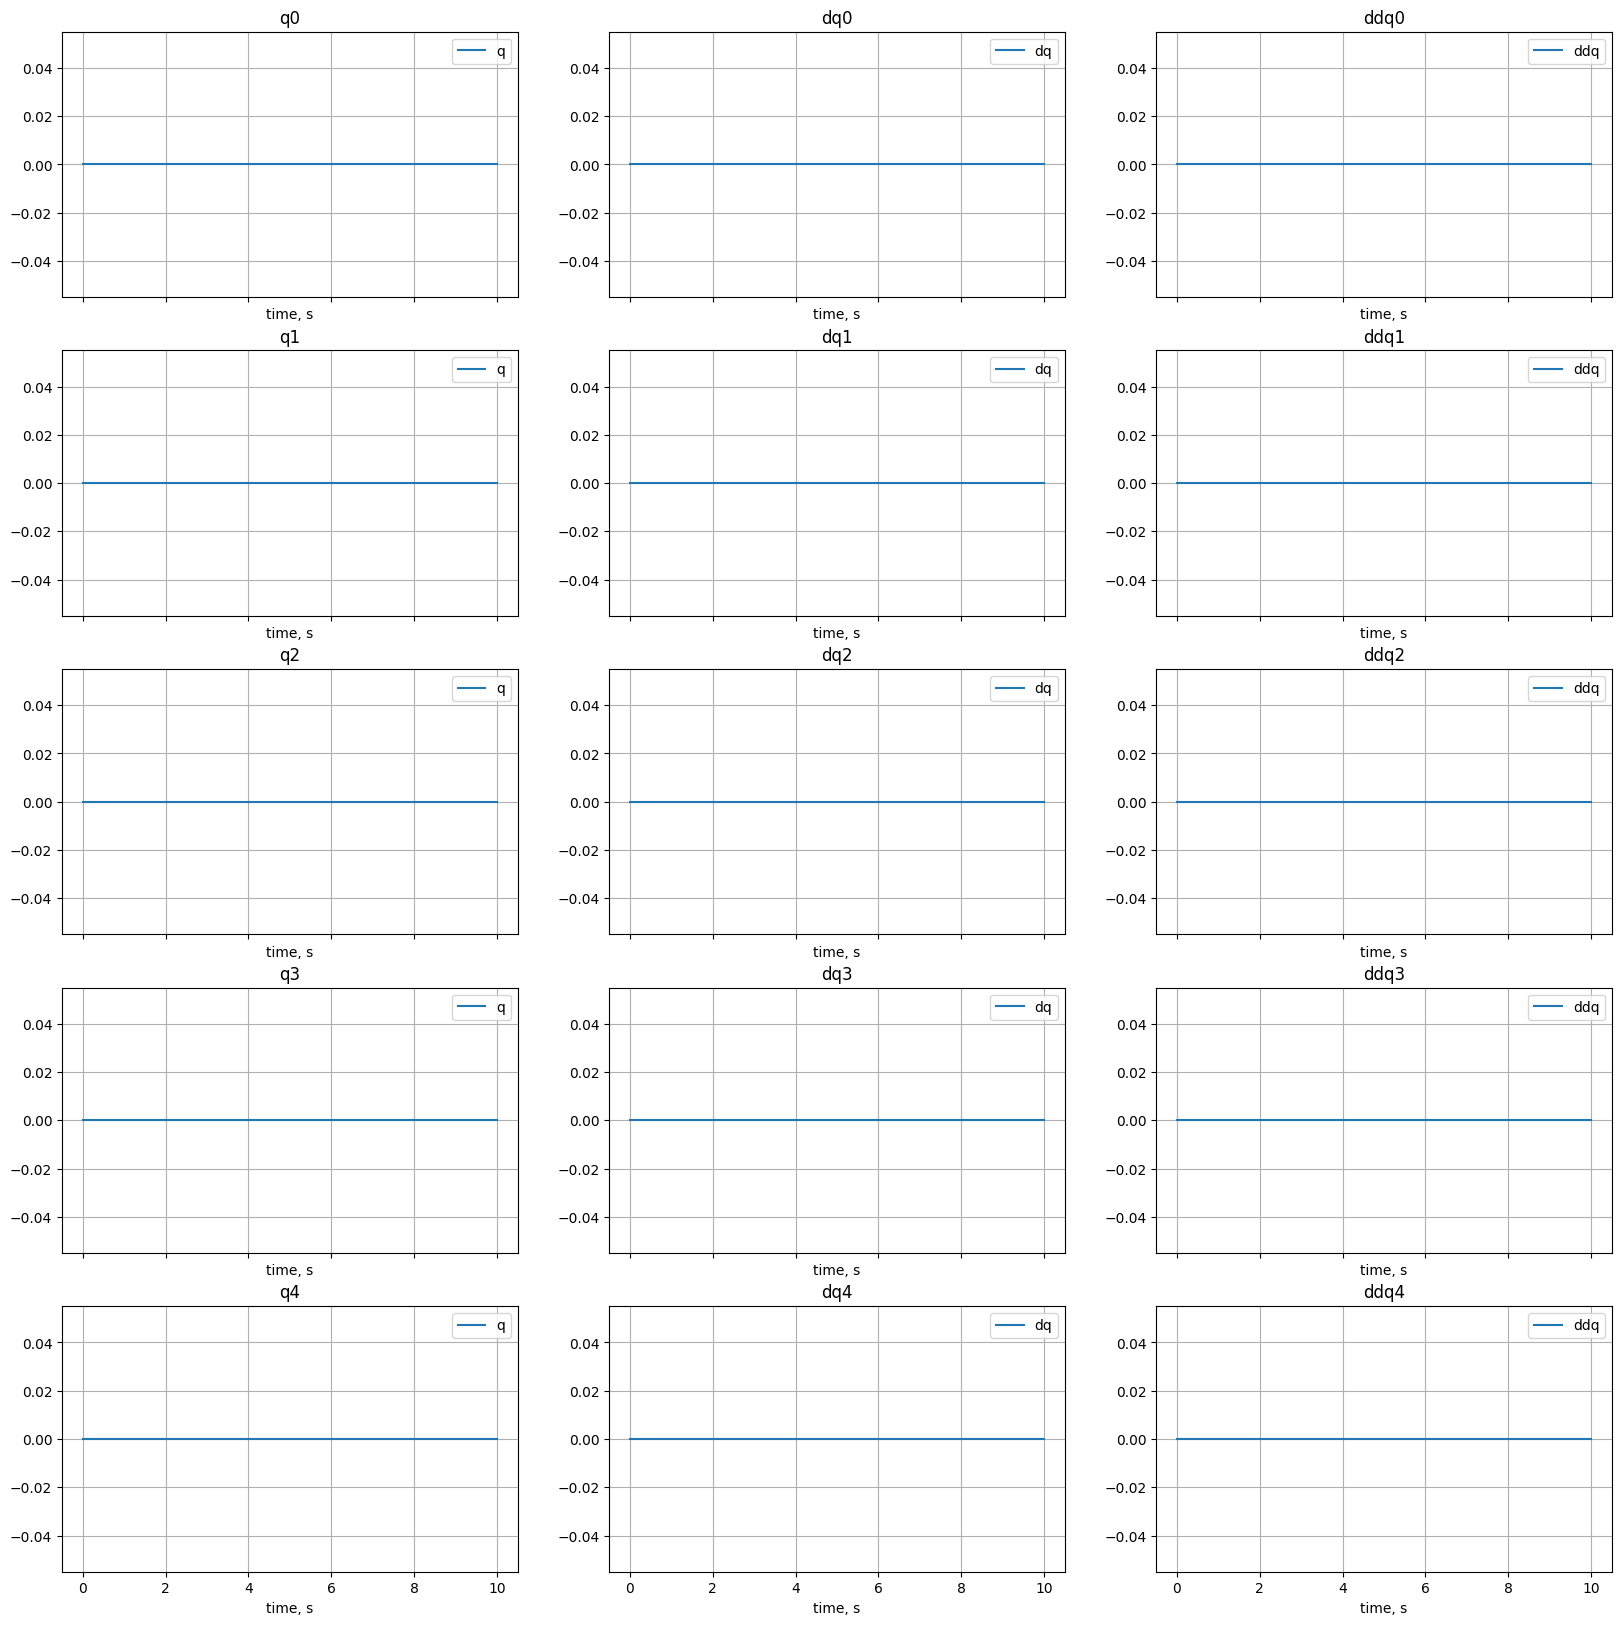

In [21]:
# define helper function to see plots from history

import matplotlib.pyplot as plt


def plot_history(history, trajectory=None):
    """
    history is assumed to contain keys: q, dq, ddq, times, torques
    """

    fig, axs = plt.subplots(5, 3, figsize=(20, 20), sharex=True)

    for i, ax in enumerate(axs):
        if trajectory:
            qdes = [trajectory[i]["q"](t) for t in history["times"]]
            dqdes = [trajectory[i]["dq"](t) for t in history["times"]]
            ddqdes = [trajectory[i]["ddq"](t) for t in history["times"]]

        ax[0].grid(True)
        ax[0].plot(history["times"], [q[i] for q in history["q"]], label="q")
        if trajectory:
            ax[0].plot(history["times"], qdes, label="qdes")
        ax[0].set_title(f"q{i}")
        ax[0].set_xlabel("time, s")
        ax[0].legend()

        ax[1].grid(True)
        ax[1].plot(history["times"], [dq[i] for dq in history["dq"]], label="dq")
        if trajectory:
            ax[1].plot(history["times"], dqdes, label="dqdes")
        ax[1].set_title(f"dq{i}")
        ax[1].set_xlabel("time, s")
        ax[1].legend()

        ax[2].grid(True)
        ax[2].plot(history["times"], [ddq[i] for ddq in history["ddq"]], label="ddq")
        if trajectory:
            ax[2].plot(history["times"], ddqdes, label="ddqdes")
        ax[2].set_title(f"ddq{i}")
        ax[2].set_xlabel("time, s")
        ax[2].legend()

    plt.show()


plot_history(history)

<img src="assets/zero_conf.png" width="500">

### Simulation seem to work because at stretched zero configuration without viscous friction manipulator is at equilibrium

## Simulation test with slightly moved joint

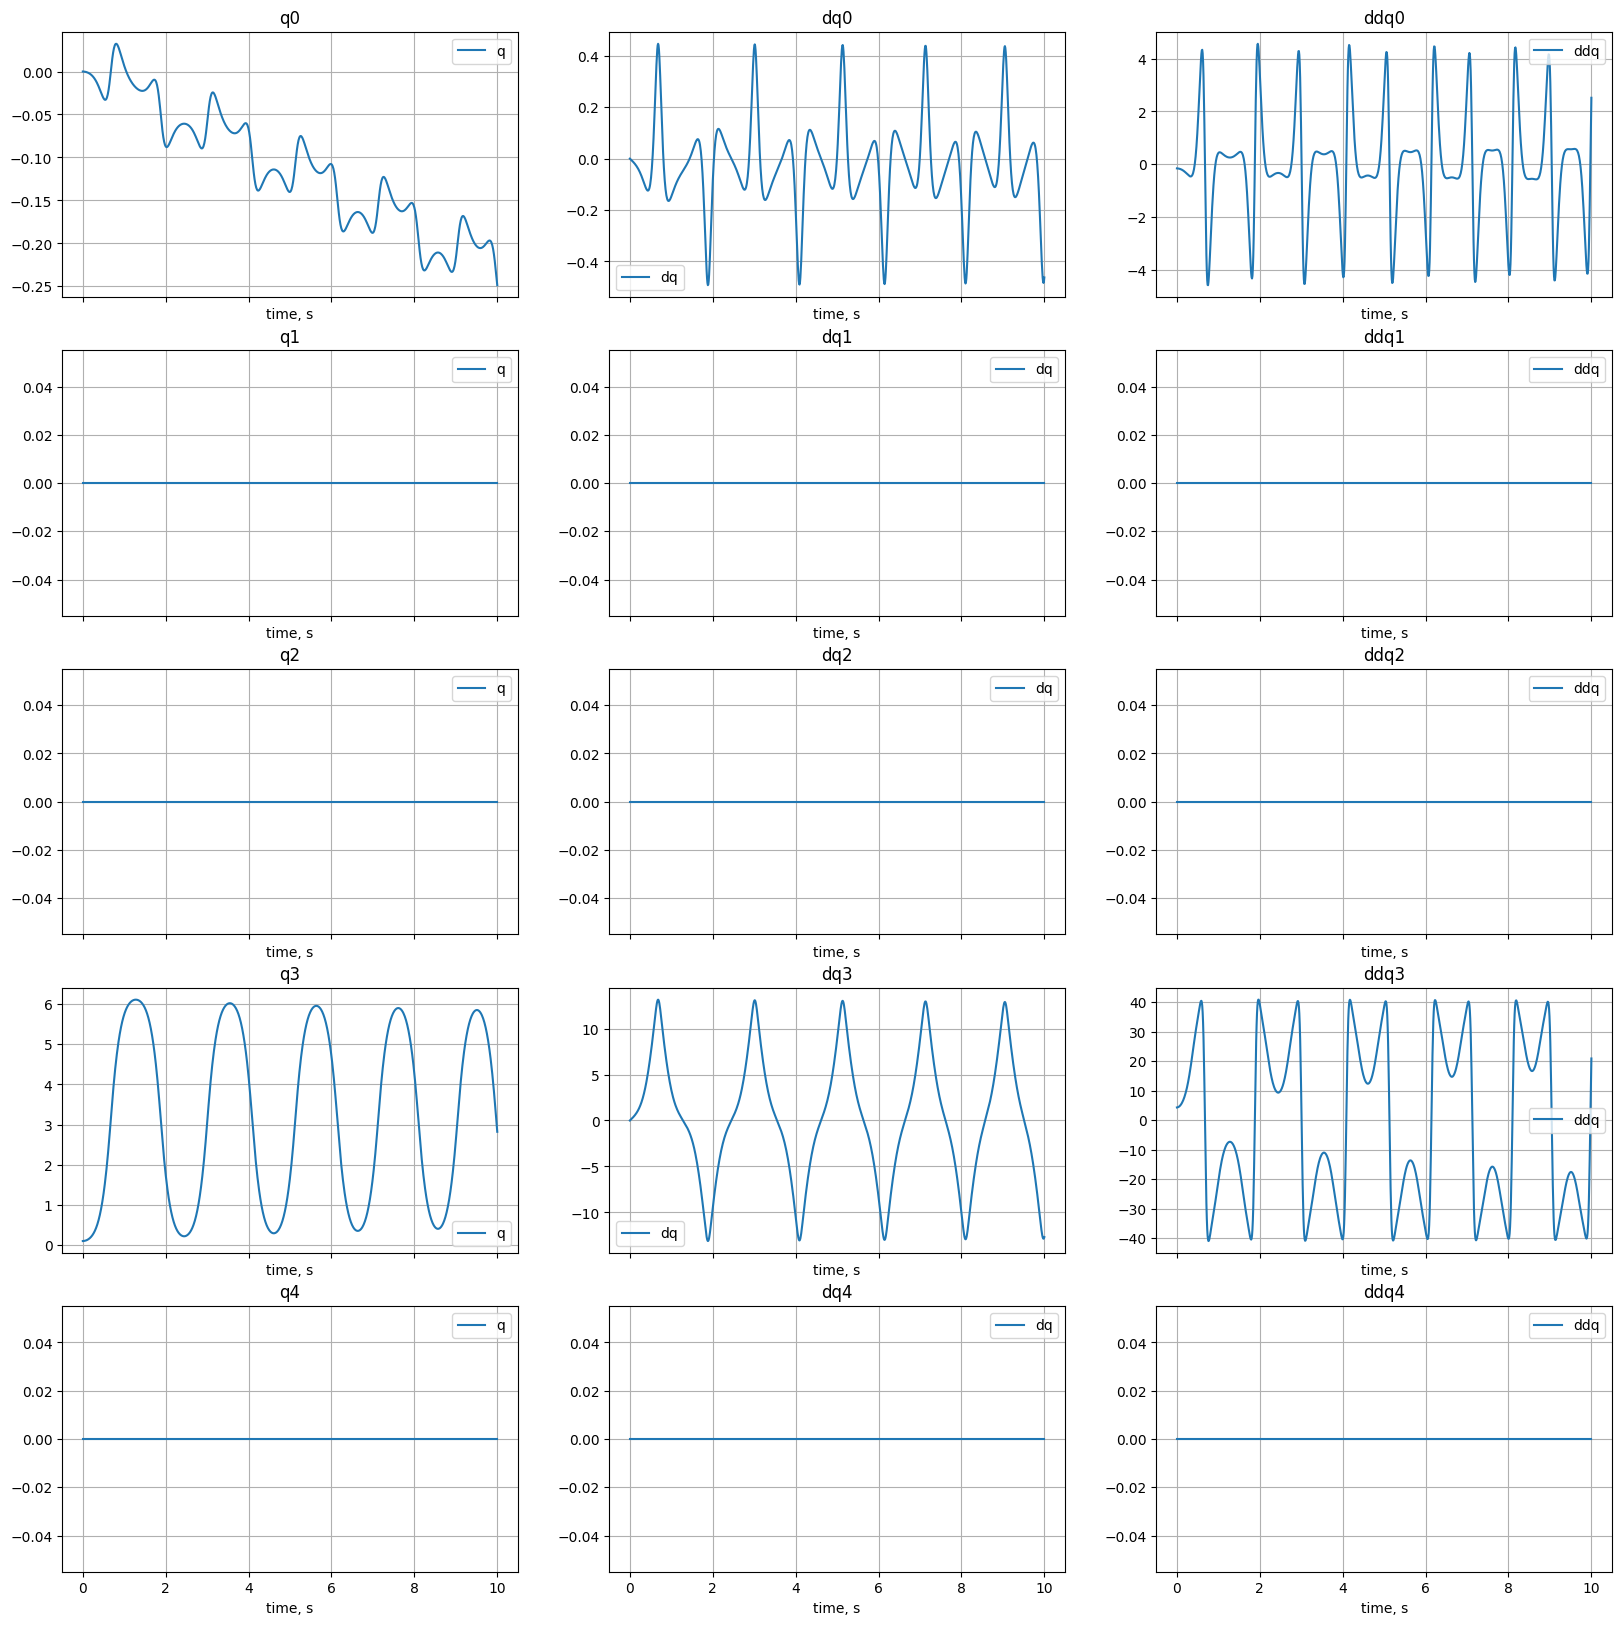

In [22]:
# try with different initial conditions

# we will try to make it fall down
q0 = np.array([0, 0, 0, 0.1, 0], dtype=np.float64)
dq0 = np.array([0, 0, 0, 0, 0], dtype=np.float64)

history = simulate_dynamics(q0, dq0, times, torques)

plot_history(history)

np.savetxt("falling_conf.txt", history["q"])

In such configuration it is pretty much cart-pole

<img src="assets/cartpole.gif">

In [23]:
# np.savetxt("history_pos.txt", history["q"])

# Control

We want to use PD controller to create PTP movement in joint space.

I propose to use following control law:

$$\tau = K_p (q_d - q) + K_d (q_d - q)$$

where $q_d$ is desired joint position, $q$ is current joint position, $K_p$ and $K_d$ are proportional and derivative gains respectively.

### Define desired trajectory

$$q_0 = \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}$$

$$q_1 = \begin{bmatrix} 0 \\ 0 \\ \pi \\ \pi/2 \\ \pi/2 \end{bmatrix}$$

$$\dot{q}_0 = 0 $$

$$\dot{q}_1 = 0 $$

Control would not only have to move manipulator to desired position, but also to hold first two prismatic joints at zero position.

I plan to reach desired position in 5 seconds.


In [24]:
q_start = np.array([0, 0, 0, 0, 0], dtype=np.float64)
dq_start = np.array([0, 0, 0, 0, 0], dtype=np.float64)
ddq_start = np.array([0, 0, 0, 0, 0], dtype=np.float64)
q_end = np.array([0, 0, np.pi, np.pi / 2, np.pi / 2], dtype=np.float64)
dq_end = np.array([0, 0, 0, 0, 0], dtype=np.float64)
ddq_end = np.array([0, 0, 0, 0, 0], dtype=np.float64)

t0 = 0
tf = 5

## For trajectory planning I decided to use quintic polynomial

- degree of polynomial should be equal to (#of constraints - 1)
- constraints:
  - q0
  - dq0
  - q1
  - dq1
  - ddq0
  - ddq1

System of equations:

$$\begin{bmatrix} 1 && t_0 && t_0^2 && t_0^3 && t_0^4 && t_0^5 \\ 0 && 1 && 2t_0 && 3t_0^2 && 4t_0^3 && 5t_0^4 \\ 1 && t_1 && t_1^2 && t_1^3 && t_1^4 && t_1^5 \\ 0 && 1 && 2t_1 && 3t_1^2 && 4t_1^3 && 5t_1^4 \\ 0 && 0 && 2 && 6t_0 && 12t_0^2 && 20t_0^3 \\ 0 && 0 && 2 && 6t_1 && 12t_1^2 && 20t_1^3 \end{bmatrix} \begin{bmatrix} a_0 \\ a_1 \\ a_2 \\ a_3 \\ a_4 \\ a_5 \end{bmatrix} = \begin{bmatrix} q_0 \\ \dot{q}_0 \\ q_1 \\ \dot{q}_1 \\ \ddot{q}_0 \\ \ddot{q}_1 \end{bmatrix}$$

This system should be solved for each joint separately.

In [25]:
from typing import List, Callable, Dict, Union


def plan_quintic(q0, dq0, ddq0, q1, dq1, ddq1, t0, t1) -> List[Dict[str, Callable]]:
    """
    given initial and final conditions, plan trajectory

    for each joint returns dict with function for position, velocity and acceleration
    """

    a_coeffs = []

    for i, (q0o, dq0i, ddq0i, q1i, dq1i, ddq1i) in enumerate(zip(q0, dq0, ddq0, q1, dq1, ddq1)):
        a = np.linalg.inv(
            np.array([
                [1, t0, t0**2, t0**3, t0**4, t0**5],
                [0, 1, 2 * t0, 3 * t0**2, 4 * t0**3, 5 * t0**4],
                [0, 0, 2, 6 * t0, 12 * t0**2, 20 * t0**3],
                [1, t1, t1**2, t1**3, t1**4, t1**5],
                [0, 1, 2 * t1, 3 * t1**2, 4 * t1**3, 5 * t1**4],
                [0, 0, 2, 6 * t1, 12 * t1**2, 20 * t1**3],
            ])) @ np.array([q0o, dq0i, ddq0i, q1i, dq1i, ddq1i])

        a_coeffs.append(a)

    result = []

    for i, a in enumerate(a_coeffs):

        def q(a0, a1, a2, a3, a4, a5):
            return lambda t: a0 + a1 * t + a2 * t**2 + a3 * t**3 + a4 * t**4 + a5 * t**5

        def dq(a0, a1, a2, a3, a4, a5):
            return lambda t: a1 + 2 * a2 * t + 3 * a3 * t**2 + 4 * a4 * t**3 + 5 * a5 * t**4

        def ddq(a0, a1, a2, a3, a4, a5):
            return lambda t: 2 * a2 + 6 * a3 * t + 12 * a4 * t**2 + 20 * a5 * t**3

        result.append({
            "q": q(*a),
            "dq": dq(*a),
            "ddq": ddq(*a),
        })

    return result


def plan_cybic(q0, dq0, ddq0, q1, dq1, ddq1, t0, t1) -> List[Dict[str, Callable]]:
    """
    given initial and final conditions, plan trajectory

    for each joint returns dict with functions for position and velocity
    """

    a_coeffs = []

    for i, (q0i, dq0i, ddq0i, q1i, dq1i, ddq1i) in enumerate(zip(q0, dq0, ddq0, q1, dq1, ddq1)):
        # q(t) = a0 + a1 * t + a2 * t^2 + a3 * t^3
        # q'(t) = a1 + 2 * a2 * t + 3 * a3 * t^2
        # q''(t) = 2 * a2 + 6 * a3 * t

        # q(t0) = q0
        # q'(t0) = dq0
        # q''(t0) = ddq0

        # q(t1) = q1
        # q'(t1) = dq1
        # q''(t1) = ddq1

        a = np.linalg.inv(
            np.array([
                [1, t0, t0**2, t0**3],
                [0, 1, 2 * t0, 3 * t0**2],
                [0, t1, t1**2, t1**3],
                [0, 1, 2 * t1, 3 * t1**2],
            ])) @ np.array([q0i, dq0i, q1i, dq1i])

        a_coeffs.append(a)

    result = []

    for i, a in enumerate(a_coeffs):
        a0, a1, a2, a3 = a
        print(i, a)

        def q(a0, a1, a2, a3, t):
            return lambda t: a0 + a1 * t + a2 * t**2 + a3 * t**3

        def dq(a0, a1, a2, a3, t):
            return lambda t: a1 + 2 * a2 * t + 3 * a3 * t**2

        def ddq(a0, a1, a2, a3, t):
            return lambda t: 2 * a2 + 6 * a3 * t

        result.append({
            "q": q(a0, a1, a2, a3, t),
            "dq": dq(a0, a1, a2, a3, t),
            "ddq": ddq(a0, a1, a2, a3, t),
        })

    return result


In [26]:
# try to simulate with planned trajectory

trajectory = plan_quintic(q_start, dq_start, ddq_start, q_end, dq_end, ddq_end, t0, tf)


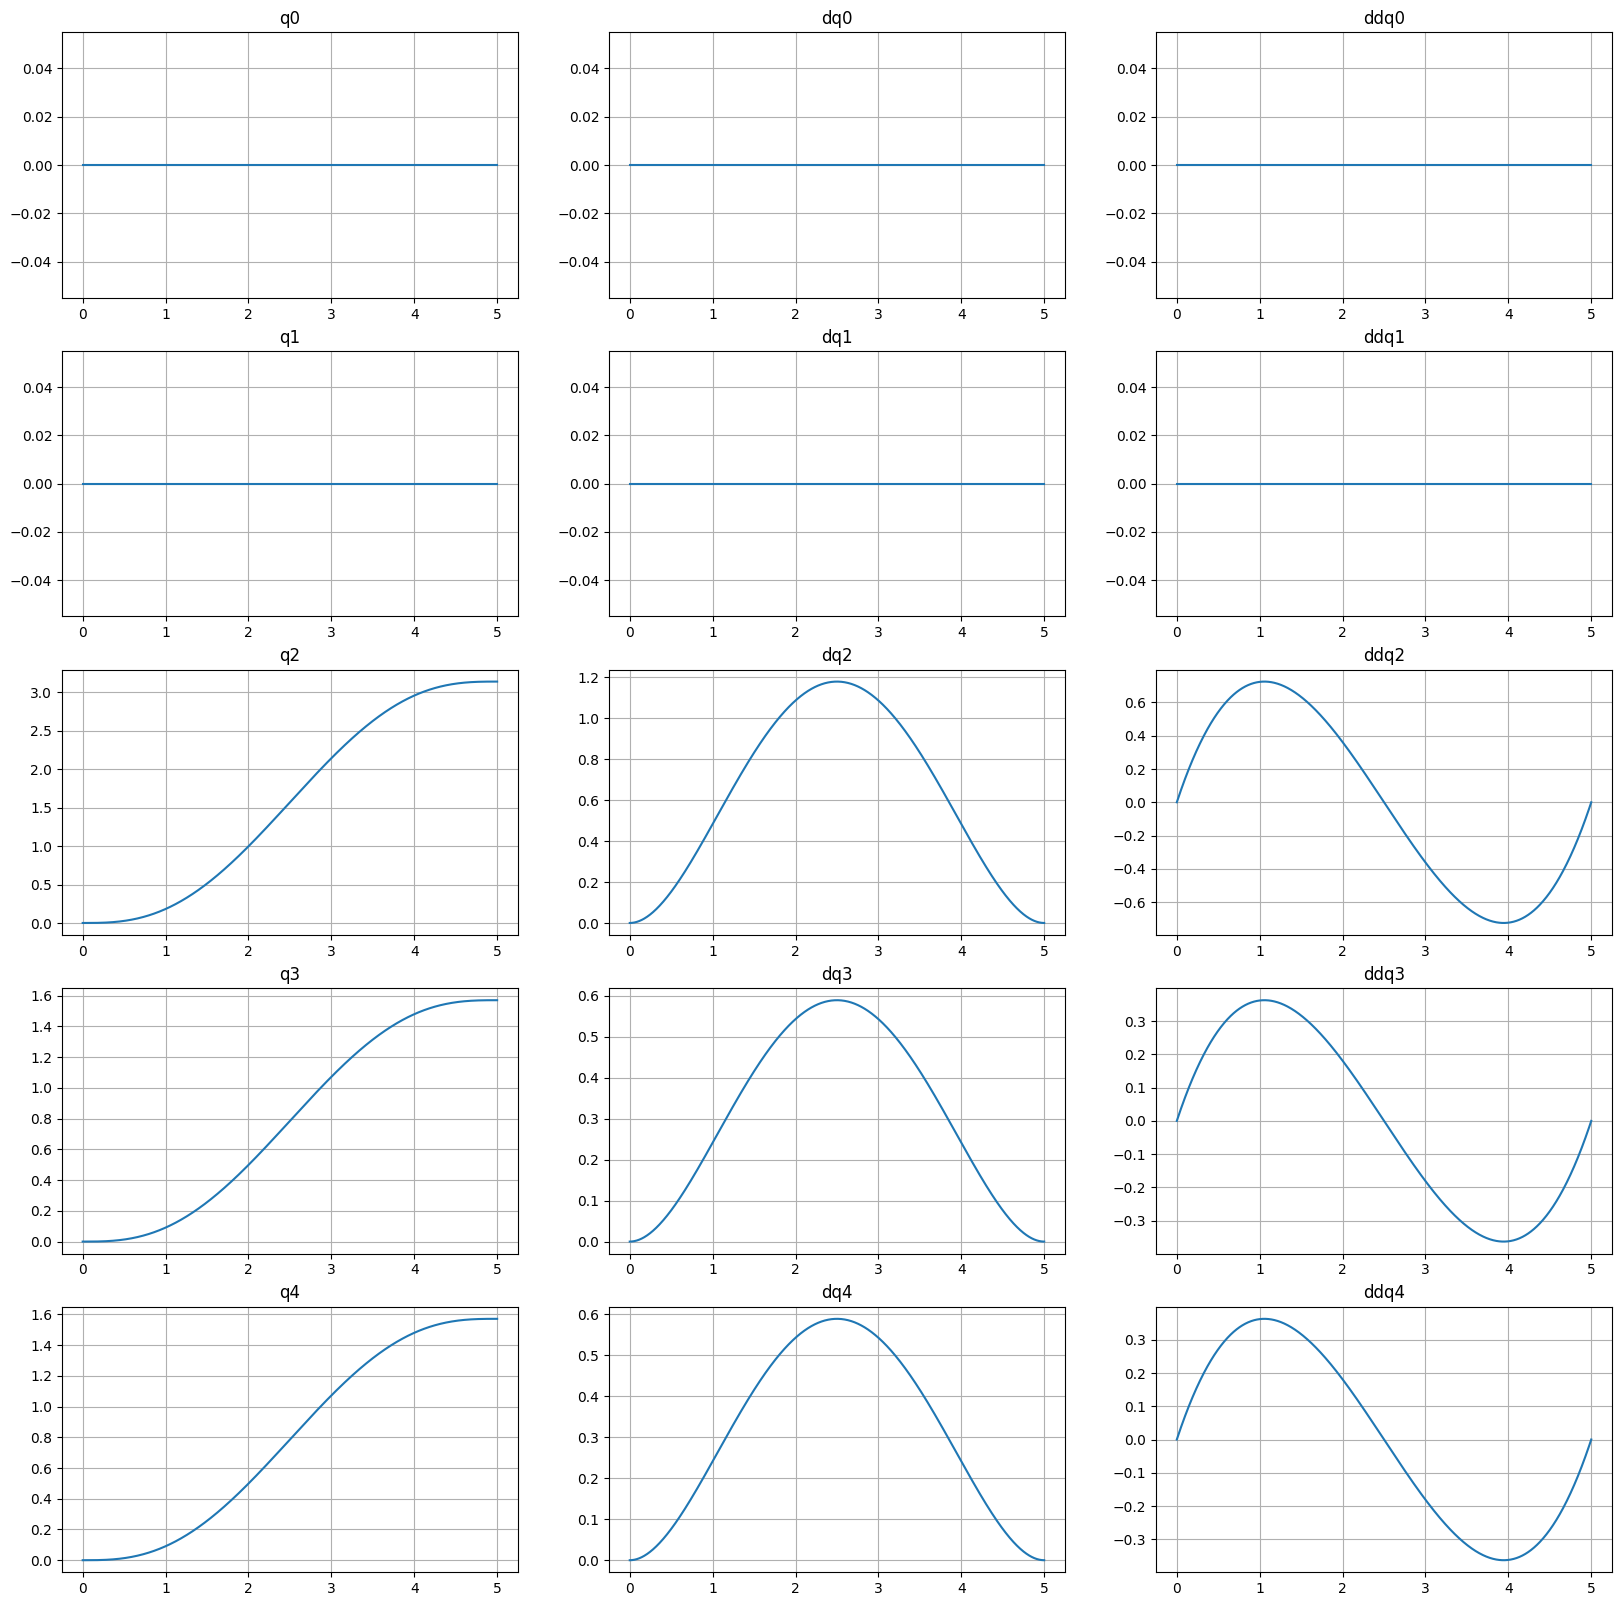

In [27]:

# plot trajectory
times = np.linspace(t0, tf, 1000)

fig, axs = plt.subplots(5, 3, figsize=(20, 20))

for i, ax in enumerate(axs):
    ax[0].grid(True)
    ax[0].plot(times, [trajectory[i]["q"](t) for t in times])
    ax[0].set_title(f"q{i}")

    ax[1].grid(True)
    ax[1].plot(times, [trajectory[i]["dq"](t) for t in times])
    ax[1].set_title(f"dq{i}")

    ax[2].grid(True)
    ax[2].plot(times, [trajectory[i]["ddq"](t) for t in times])
    ax[2].set_title(f"ddq{i}")

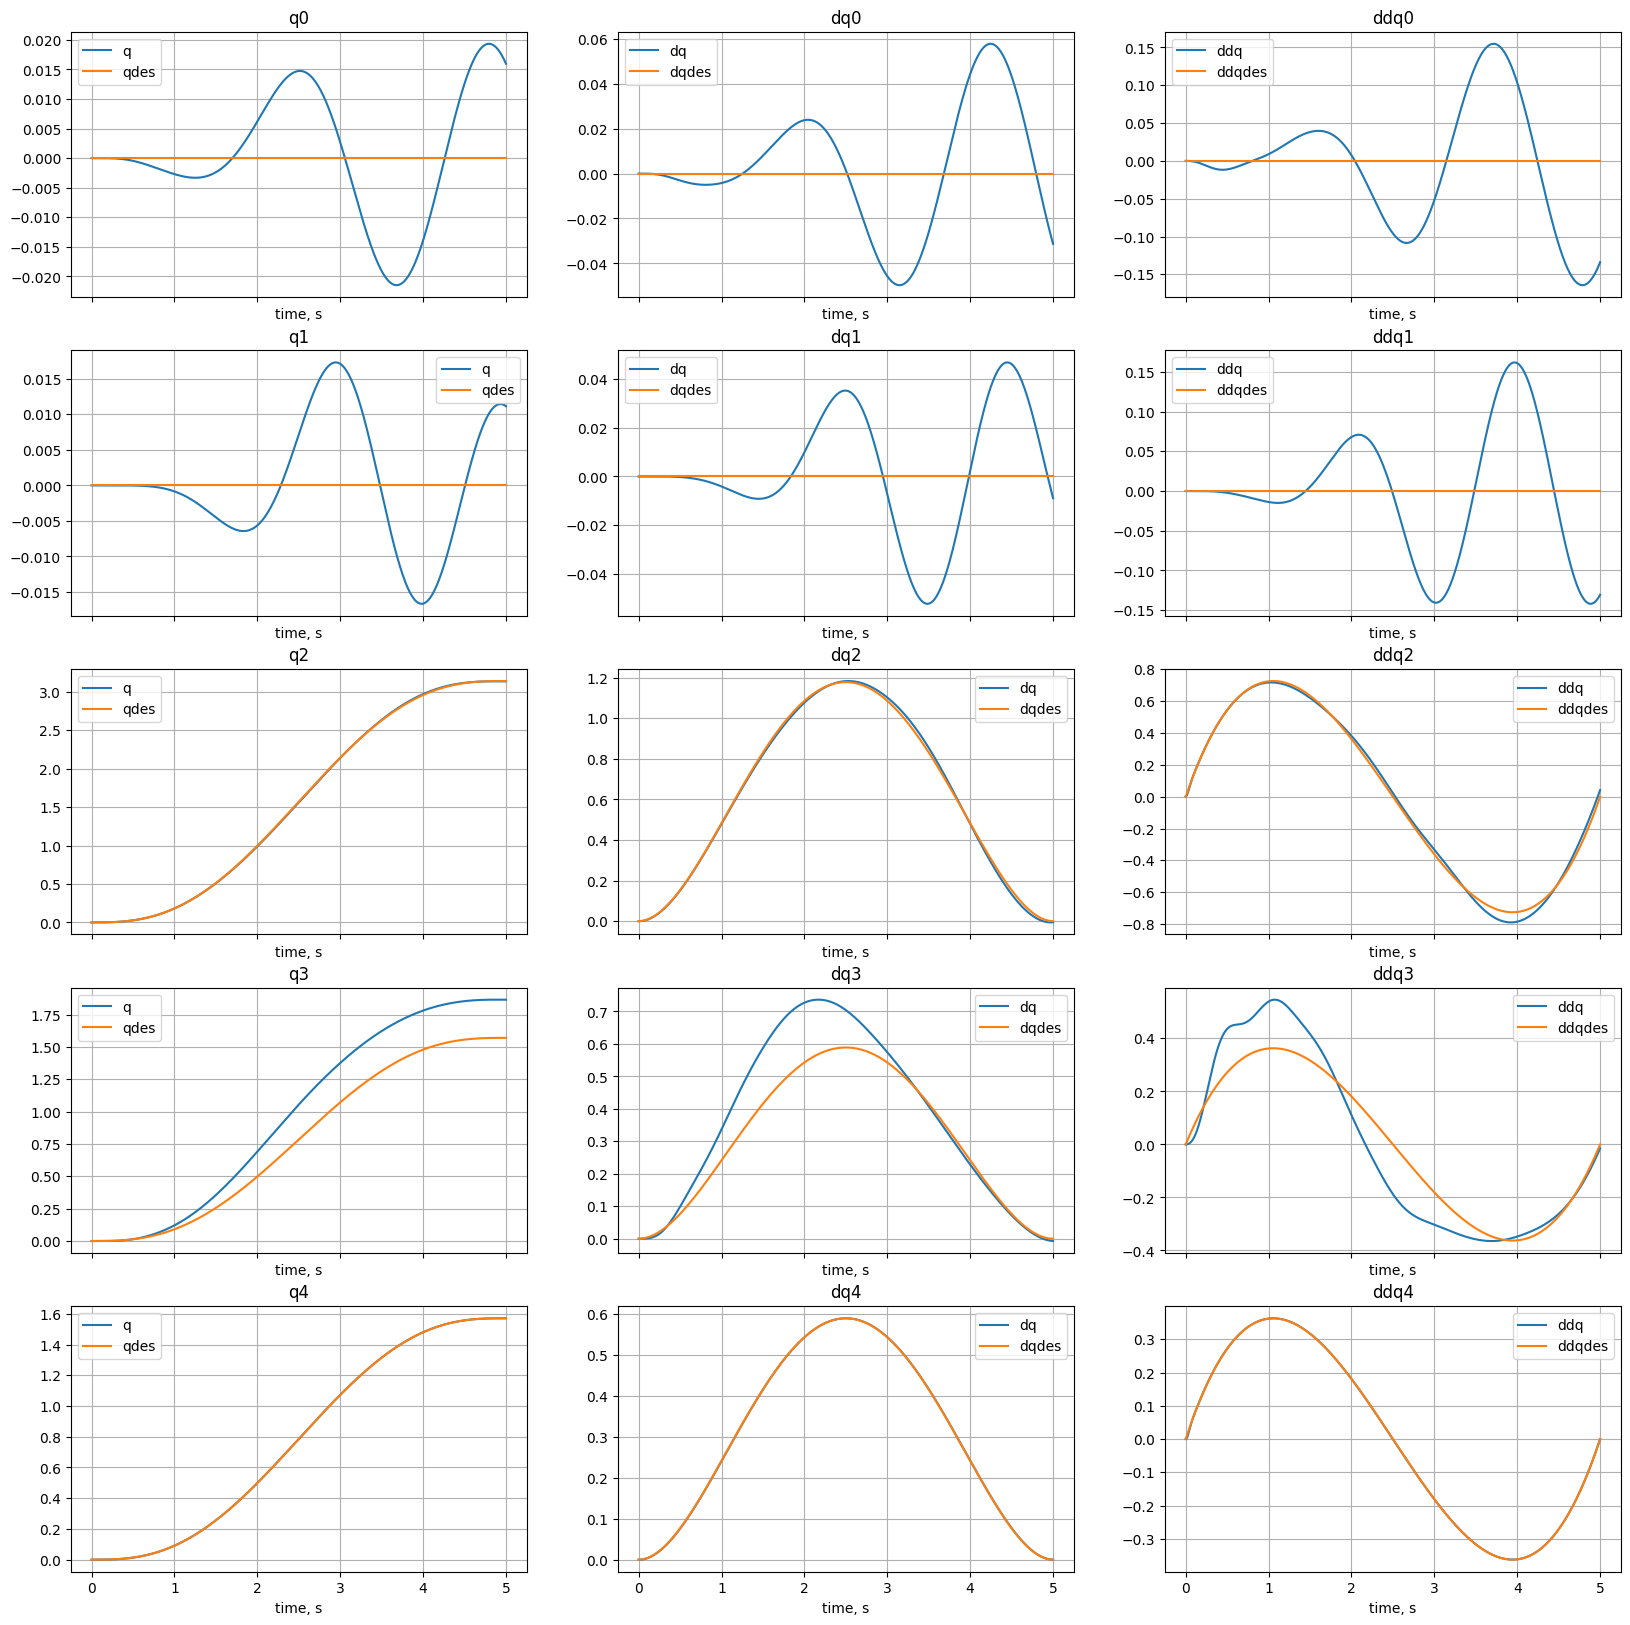

In [28]:
times = np.linspace(t0, tf, 1000)

q0 = np.array([0, 0, 0, 0, 0], dtype=np.float64)
dq0 = np.array([0, 0, 0, 0, 0], dtype=np.float64)


def torques_old(t, q, dq):
    """
    return the list of torques for all joints
    """

    gains = [
        {
            "kp": 30,
            "kd": 0.3,
        },
        {
            "kp": 30,
            "kd": 0.3,
        },
        {
            "kp": 4,
            "kd": 0.1,
        },
        {
            "kp": 4,
            "kd": 0.1,
        },
        {
            "kp": 4,
            "kd": 0.1,
        },
    ]

    q_des = np.array([trajectory[i]["q"](t) for i in range(5)], dtype=np.float64)
    dq_des = np.array([trajectory[i]["dq"](t) for i in range(5)], dtype=np.float64)

    e = q_des - q
    de = dq_des - dq

    kp = np.diag([gains[i]["kp"] for i in range(5)])
    kd = np.diag([gains[i]["kd"] for i in range(5)])

    return kp @ e + kd @ de


history = simulate_dynamics(q0, dq0, times, torques_old)

plot_history(history, trajectory)


# Show expected and actual trajectory

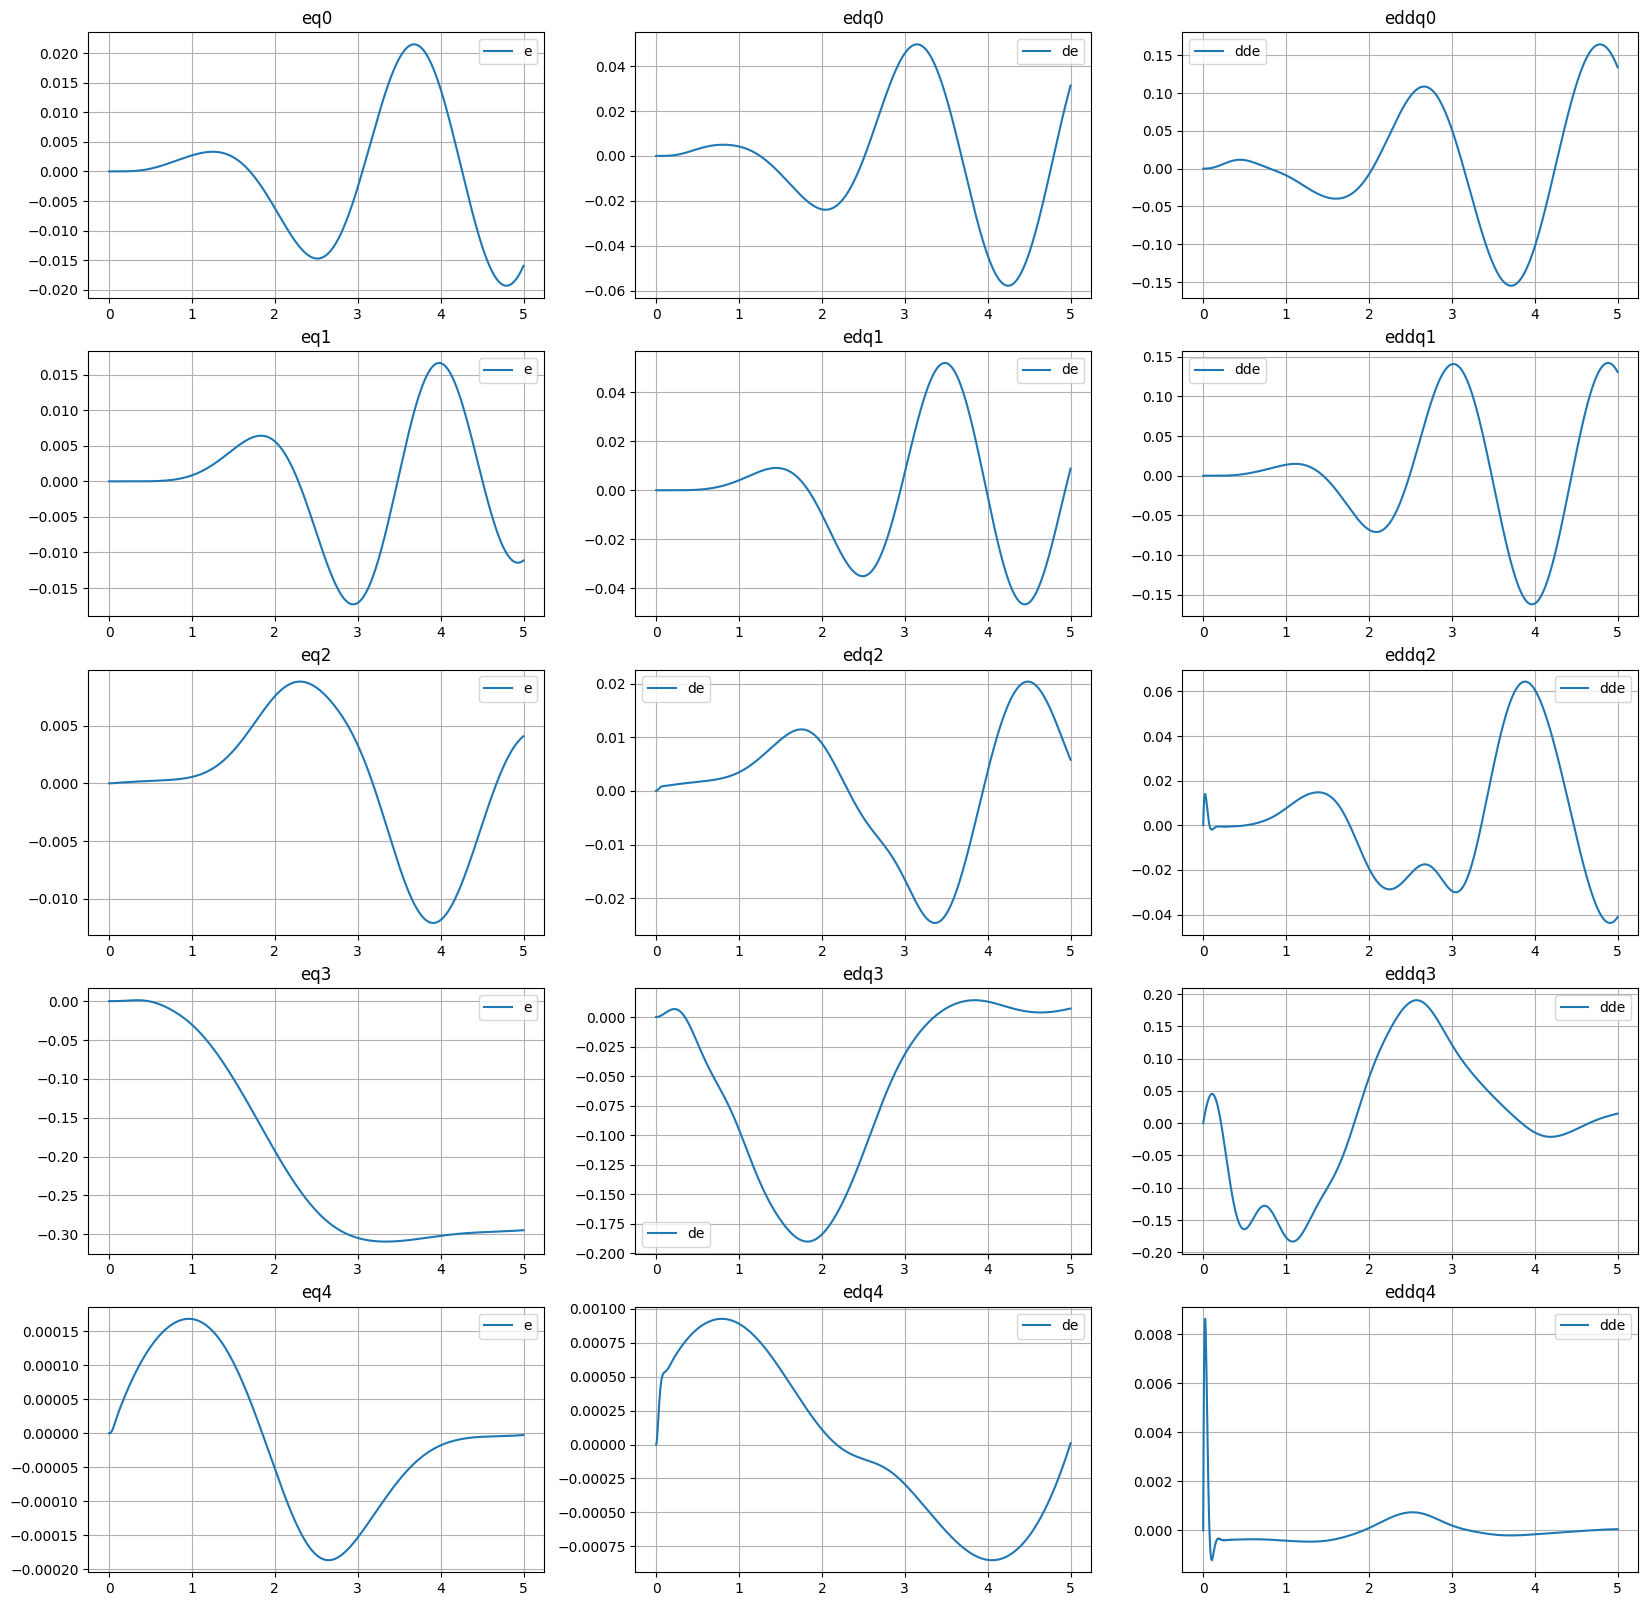

In [29]:
def plot_history_error(trajectory, history):
    # calculate the error
    q = np.array(history["q"])
    dq = np.array(history["dq"])
    ddq = np.array(history["ddq"])
    time = np.array(history["times"])

    q_des = []
    dq_des = []
    ddq_des = []
    for t, qi, dqi in zip(time, q, dq):
        q_des.append([trajectory[i]["q"](t) for i in range(5)])
        dq_des.append([trajectory[i]["dq"](t) for i in range(5)])
        ddq_des.append([trajectory[i]["ddq"](t) for i in range(5)])

    q_des = np.array(q_des)
    dq_des = np.array(dq_des)
    ddq_des = np.array(ddq_des)

    e = q_des - q
    de = dq_des - dq
    dde = ddq_des - ddq

    fig, axs = plt.subplots(5, 3, figsize=(20, 20))

    for i, ax in enumerate(axs):
        ax[0].grid(True)
        ax[0].plot(times, e[:, i], label="e")

        ax[0].set_title(f"eq{i}")
        ax[0].legend()

        ax[1].grid(True)
        ax[1].plot(times, de[:, i], label="de")

        ax[1].set_title(f"edq{i}")
        ax[1].legend()

        ax[2].grid(True)
        ax[2].plot(times, dde[:, i], label="dde")

        ax[2].set_title(f"eddq{i}")
        ax[2].legend()


plot_history_error(trajectory, history)

# Feedback linearization design

As we see results are not satisfying. We could try to use feedback linearization to improve results.

The main problem with previous approach is that we do not directly control joint accelerations, but their are mixed. We could try to use feedback linearization to decouple them.

Idea is that we could make $\tau$ mimic $\ddot{q}$.

$$\tau = M(q) a_q + c(q, \dot{q}) \dot{q} + G(q)$$

where $a_q$ is the virtual control.

After substituting $\tau$ we get:

$$\ddot{q} = a_q$$

Now we choose virtual control as PD-controller:

$$a_q = \ddot{q}^{des} - K_p (q_d - q) + K_d (q_d - q)$$

this way we achieve decoupling and stabilizing.

Kp and Kd could be positive definite diagonal matrices in form:

$$K_p = diag\{w_{n1}^2, ..., w_{nn}^2\}$$

$$K_d = diag\{2 \zeta_1 w_{n1}, ..., 2 \zeta_n w_{nn}\}$$

where $w_{ni}$ are natural frequencies of each joint and $\zeta$ is damping ratio.

I attempted to use Kp and Kd defined through frequencies and damping ratio, but it did not satisfy me.

I decided to select Kp and Kd manually.


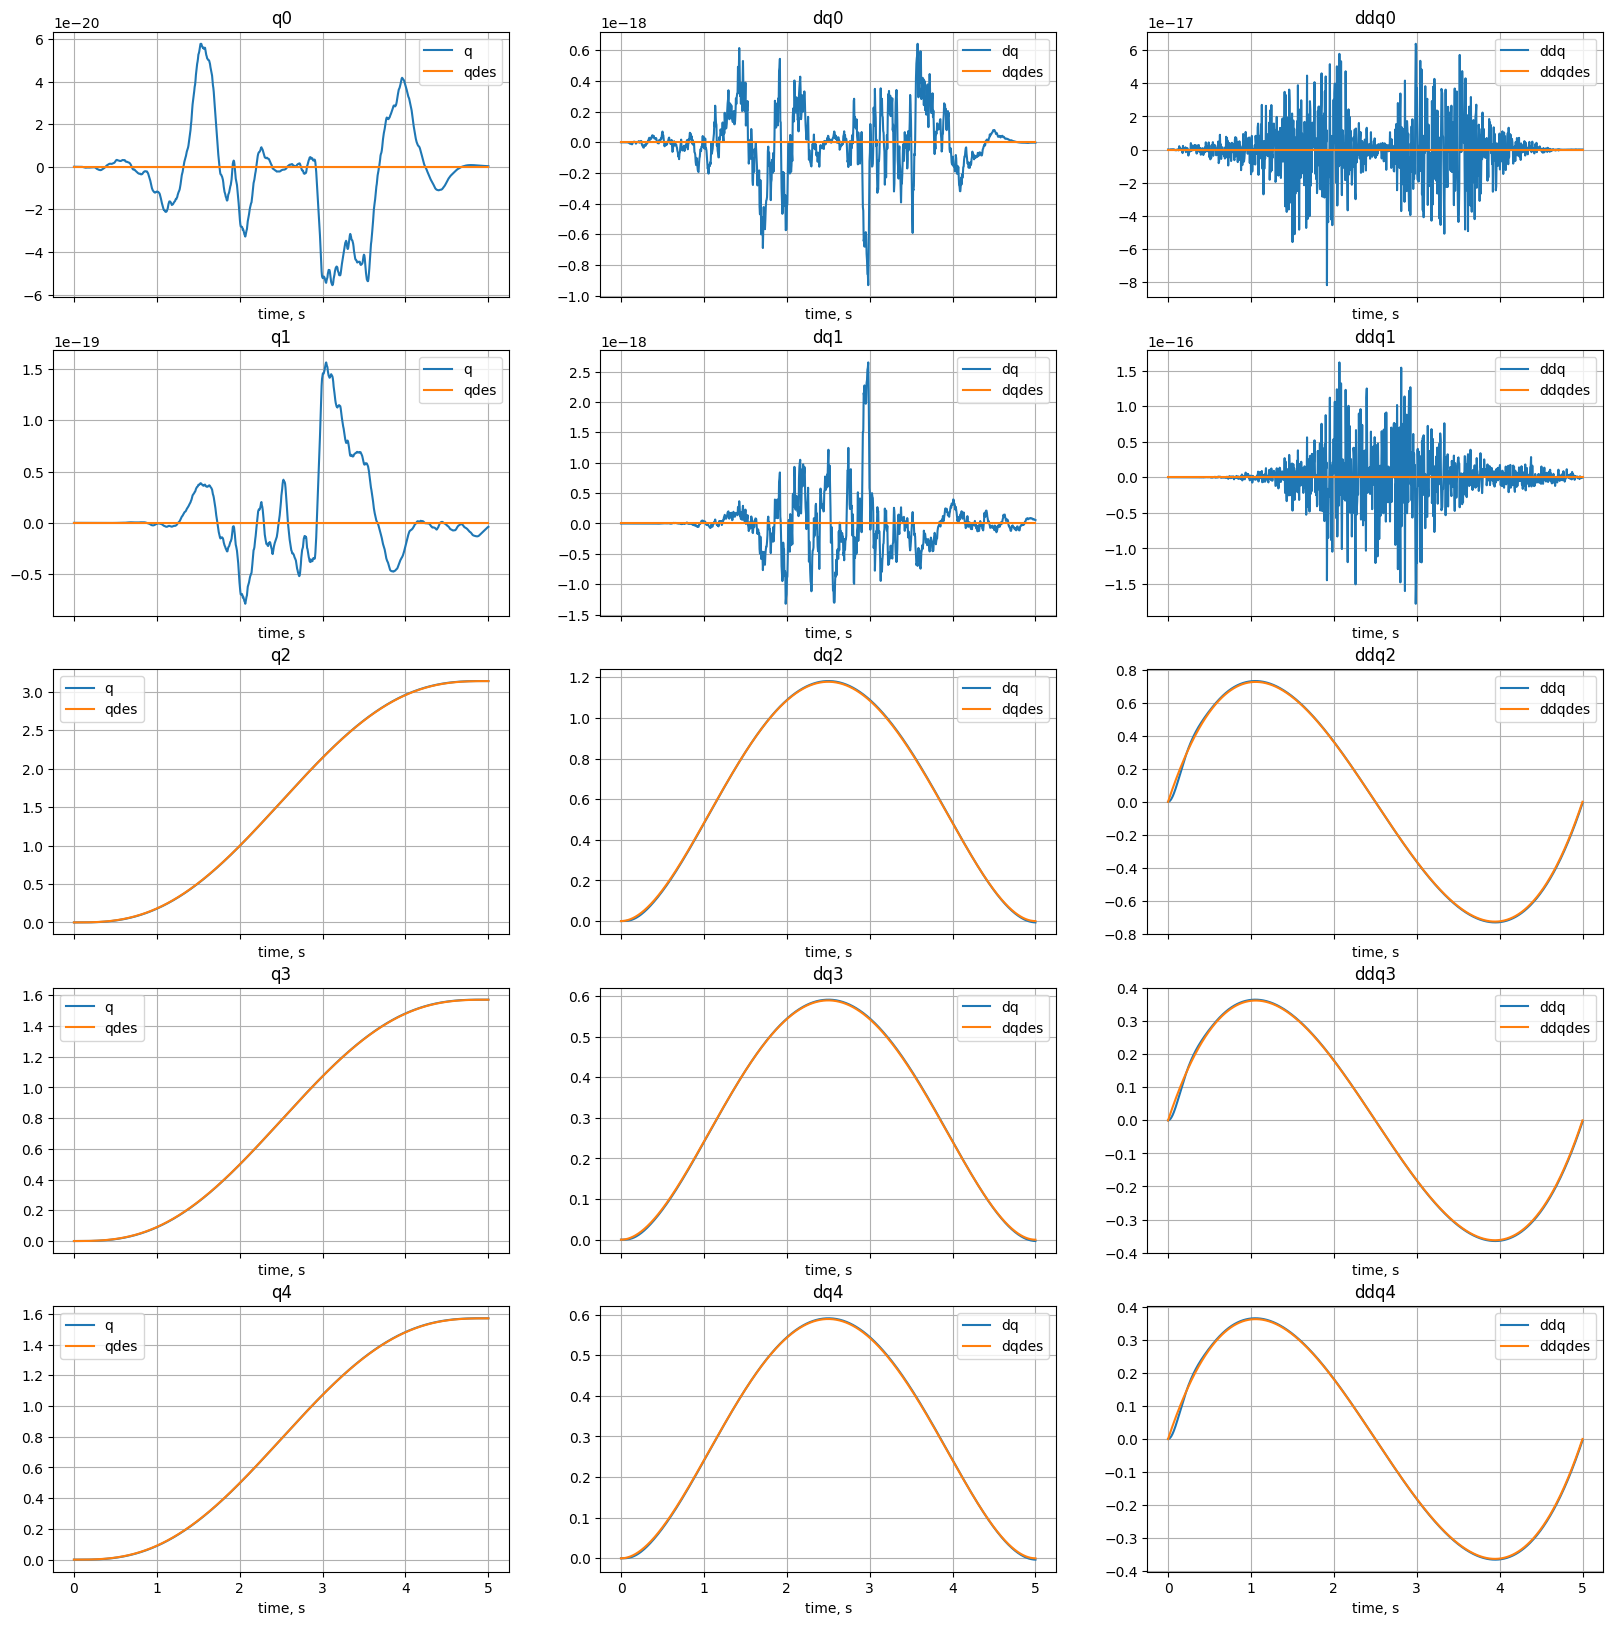

In [30]:
def torques_gen(t, q, dq):
    """
    return the list of torques for all joints
    """

    q_des = np.array([trajectory[i]["q"](t) for i in range(5)])
    dq_des = np.array([trajectory[i]["dq"](t) for i in range(5)])

    e = q_des - q
    de = dq_des - dq

    kp = np.diag([100, 100, 200, 200, 200])
    kd = np.diag([15, 15, 15, 15, 15])

    inertia = inertia_func(*q)
    coriolis = coriolis_func(q, dq)
    gravity = gravity_func(*q)[:, 0]

    return inertia @ (kp @ e + kd @ de) + coriolis @ dq + gravity


history = simulate_dynamics(q0, dq0, times, torques_gen)

plot_history(history, trajectory)

np.savetxt("planner.txt", np.array(history["q"]))

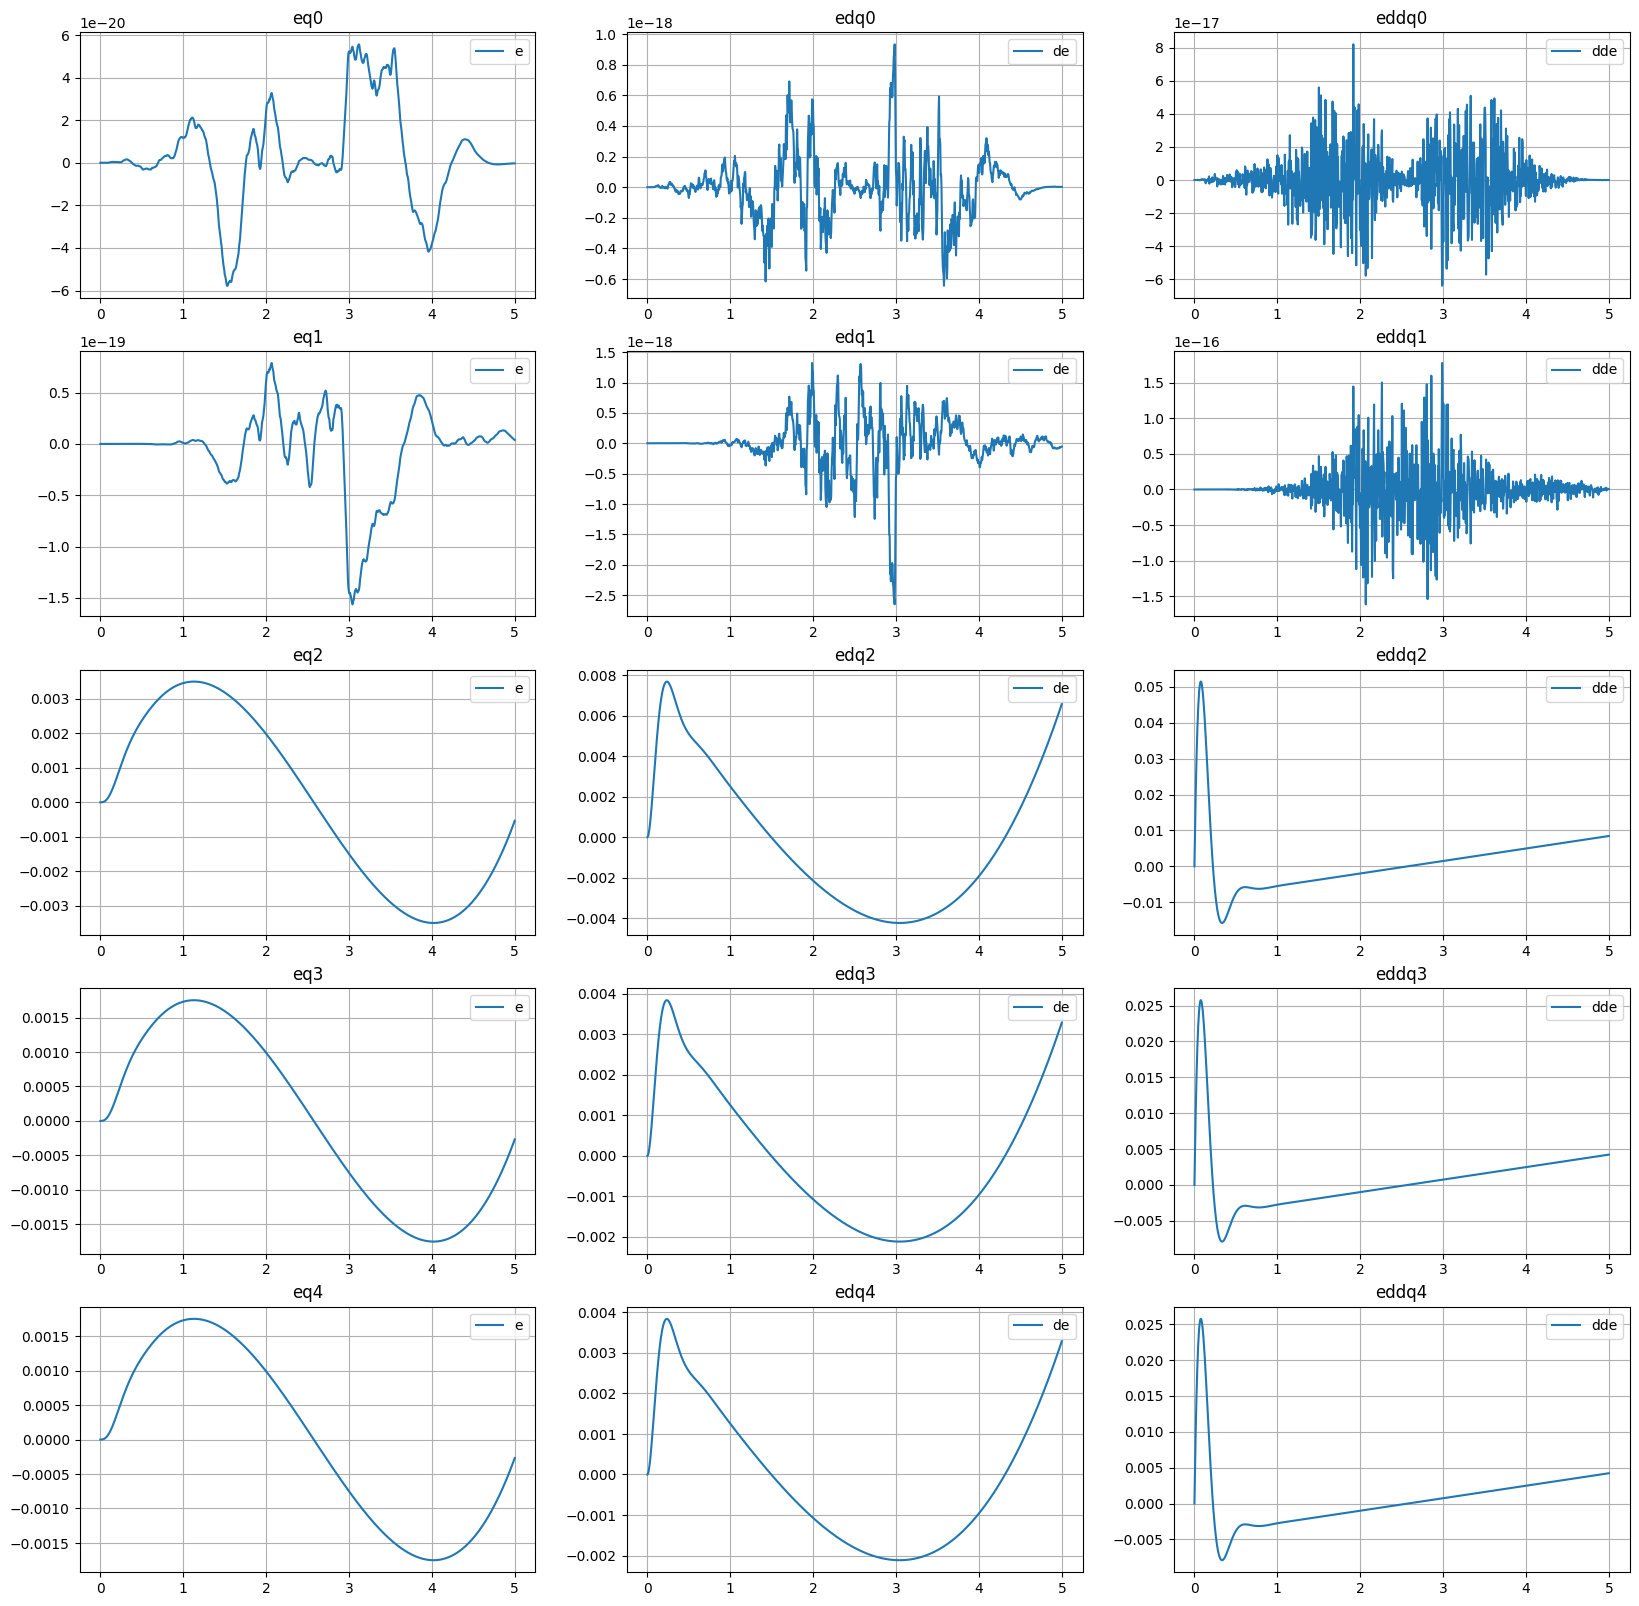

In [31]:
plot_history_error(trajectory, history)

![Alt text](assets/planner.gif)

## I was kind of disappointed with results, but overall decoupling of system through feedback linearization have given us more predictable result of kp and kd tuning.